In [1]:
import pandas as pd
import numpy as np
import re
import os
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
from scipy import stats

%matplotlib inline
plt.style.use('ggplot')
%config InlineBackend.figure_format = 'retina'

import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm_notebook as tq

In [2]:
DATA_DIR = "../game_num_data/"

In [3]:
def make_df():
    columns = ["状況", "回"]
    event_list = []
    for file in tq(os.listdir(DATA_DIR)[1:]):
        curr_event_list = pd.read_csv(DATA_DIR+file, encoding="cp932", index_col=0, dtype="object")[columns].values.tolist()
        new_event_list = []
        for i in range(len(curr_event_list)):
            new_event_list.append(curr_event_list[i])
            if i < len(curr_event_list)-1 and curr_event_list[i][0] == "2" and curr_event_list[i+1][0] == "1":
                new_event_list.append(["3000", curr_event_list[i][1]])
                new_event_list.append(["0000", curr_event_list[i+1][1]])
        event_list.extend(new_event_list+[["GAMESET", np.nan]])
    for i in range(len(event_list)):
        if event_list[i][1] is np.nan:
            if event_list[i][0] != "GAMESET":
                event_list[i][1] = event_list[i-1][1]
    return pd.DataFrame(event_list, columns=columns)

In [4]:
event_df = make_df()

In [25]:
len(event_df)

81701

In [5]:
event_df.head()

,状況,回
0,0000,1回表
1,1000,1回表
2,2000,1回表
3,3000,1回表
4,0000,1回裏


In [6]:
inning_list = []
for inning in range(10):
    curr_inning_list = []
    for i in range(len(event_df)):
        if event_df.iloc[i, 0] == "GAMESET":
            continue
        if int(event_df.iloc[i, 1].split("回")[0]) == inning + 1:
            curr_inning_list.append(event_df.iloc[i, 0])
    inning_list.append(curr_inning_list)

In [7]:
inning_triple_list = []
for inning in range(len(inning_list)):
    curr_triple = []
    for i in range(2, len(inning_list[inning])):
        before, curr, after = inning_list[inning][i-2], inning_list[inning][i-1], inning_list[inning][i]
        if "GAMESET" in [before, curr, after]:
            continue
        if before == "3000" or curr == "3000":
            continue
        curr_triple.append((before, curr, after))
    inning_triple_list.append(curr_triple)

In [8]:
len(inning_triple_list)

10

In [9]:
all_triple_list = []
for triple_list in inning_triple_list:
    all_triple_list += triple_list
all_triple_set = set(all_triple_list)

In [10]:
# 状況とインデックスの対応dict
case_dict = dict()
for i, triple in enumerate(all_triple_set):
    case_dict[triple] = i

In [11]:
def to_index(lst):
    return [case_dict[elem] for elem in lst]

In [12]:
inning_triple_index_list = []
for lst in inning_triple_list:
    inning_triple_index_list.append(to_index(lst))

In [22]:
len(inning_triple_index_list), len(inning_triple_index_list[0])

(10, 5959)

In [13]:
# KS検定の結果
df_statistic = pd.DataFrame(index=[_ for _ in range(1, 10)], columns=[_ for _ in range(1, 10)]).astype(float)
for i in range(9):
    for j in range(9):
        df_statistic.iloc[i, j] = stats.ks_2samp(inning_triple_index_list[i], inning_triple_index_list[j]).statistic

In [29]:
stats.ks_2samp(inning_triple_index_list[0], inning_triple_index_list[0])

Ks_2sampResult(statistic=0.0, pvalue=1.0)

In [14]:
df_statistic

,1,2,3,4,5,6,7,8,9
1,0.000000,0.027820,0.021800,0.023460,0.035597,0.012422,0.021800,0.013885,0.033567
2,0.027820,0.000000,0.016121,0.009434,0.019051,0.018373,0.021845,0.026594,0.020297
3,0.021800,0.016121,0.000000,0.011835,0.018690,0.014717,0.015666,0.020497,0.020363
4,0.023460,0.009434,0.011835,0.000000,0.015542,0.015558,0.016858,0.022082,0.017022
5,0.035597,0.019051,0.018690,0.015542,0.000000,0.028591,0.026761,0.035605,0.011110
6,0.012422,0.018373,0.014717,0.015558,0.028591,0.000000,0.012086,0.010423,0.024767
7,0.021800,0.021845,0.015666,0.016858,0.026761,0.012086,0.000000,0.020431,0.023612
8,0.013885,0.026594,0.020497,0.022082,0.035605,0.010423,0.020431,0.000000,0.030220
9,0.033567,0.020297,0.020363,0.017022,0.011110,0.024767,0.023612,0.030220,0.000000


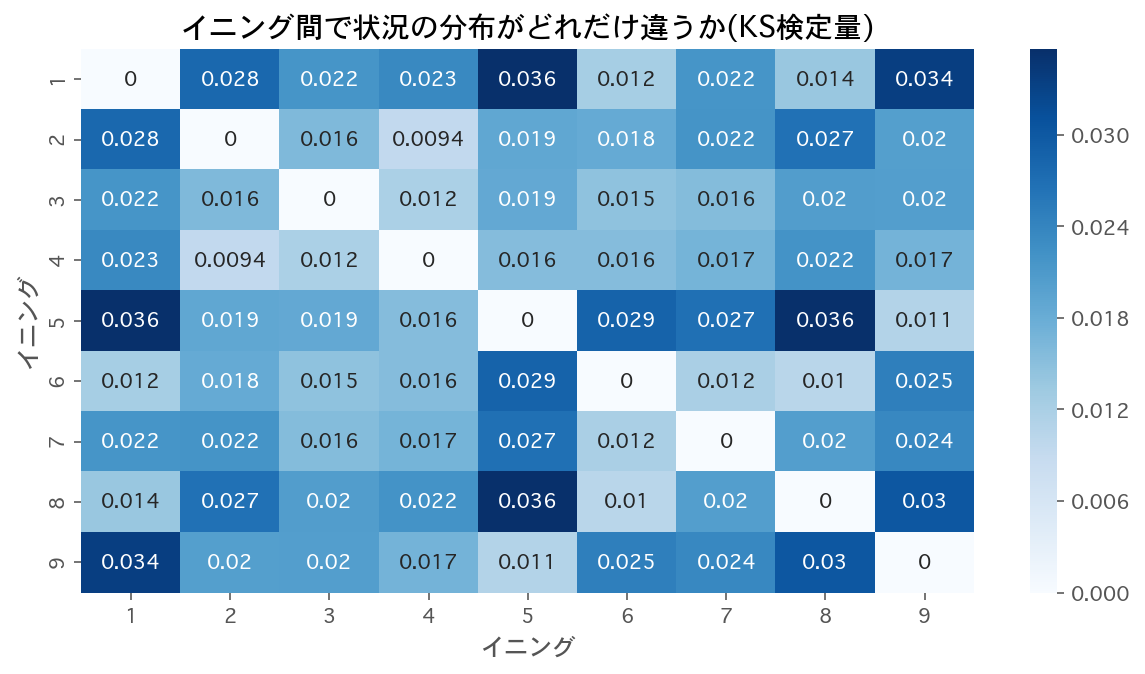

In [15]:
plt.figure(figsize=(10, 5))
sns.heatmap(df_statistic, cmap="Blues", annot=True)
plt.xlabel("イニング")
plt.ylabel("イニング")
plt.title("イニング間で状況の分布がどれだけ違うか(KS検定量)")

In [16]:
# KS検定の結果
df_pvalue = pd.DataFrame(index=[_ for _ in range(1, 10)], columns=[_ for _ in range(1, 10)]).astype(float)
for i in range(9):
    for j in range(9):
        df_pvalue.iloc[i, j] = stats.ks_2samp(inning_triple_index_list[i], inning_triple_index_list[j]).pvalue

In [17]:
df_pvalue

,1,2,3,4,5,6,7,8,9
1,1.000000,0.023468,0.123538,0.082490,0.001359,0.757701,0.127914,0.626470,0.006918
2,0.023468,1.000000,0.457649,0.965421,0.267872,0.299331,0.140861,0.037814,0.269677
3,0.123538,0.457649,1.000000,0.821746,0.278212,0.564671,0.490221,0.180745,0.257415
4,0.082490,0.965421,0.821746,1.000000,0.510673,0.499450,0.403281,0.126706,0.477714
5,0.001359,0.267872,0.278212,0.510673,1.000000,0.020073,0.037003,0.001603,0.924785
6,0.757701,0.299331,0.564671,0.499450,0.020073,1.000000,0.803163,0.915665,0.097087
7,0.127914,0.140861,0.490221,0.403281,0.037003,0.803163,1.000000,0.188950,0.131081
8,0.626470,0.037814,0.180745,0.126706,0.001603,0.915665,0.188950,1.000000,0.022225
9,0.006918,0.269677,0.257415,0.477714,0.924785,0.097087,0.131081,0.022225,1.000000


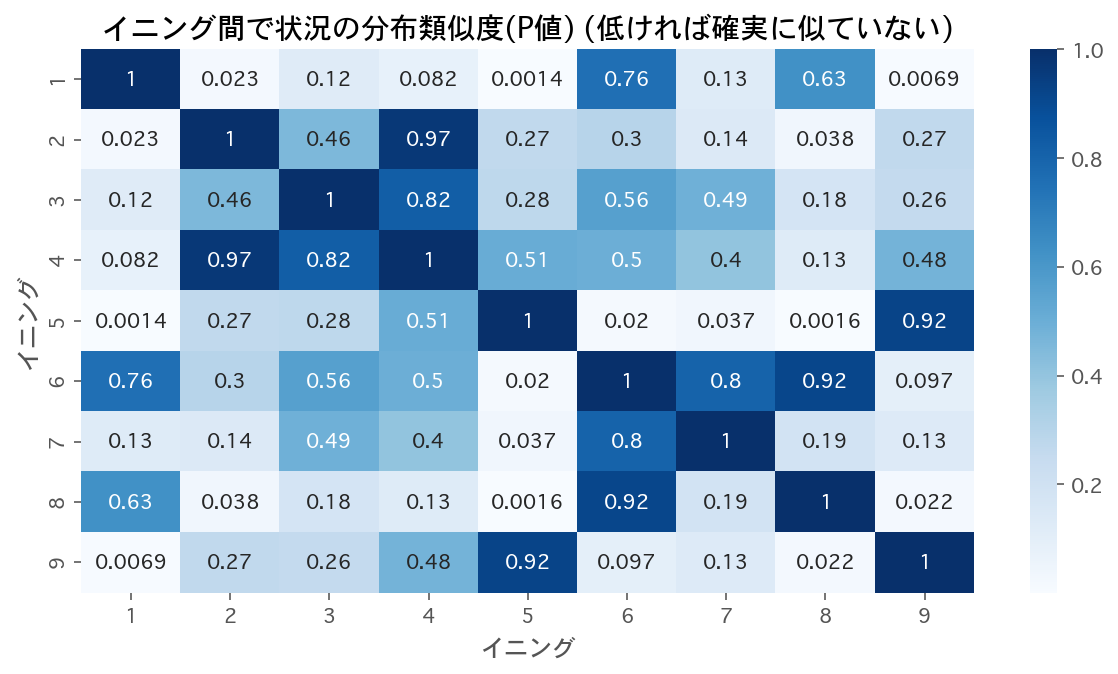

In [18]:
plt.figure(figsize=(10, 5))
sns.heatmap(df_pvalue, cmap="Blues", annot=True)
plt.xlabel("イニング")
plt.ylabel("イニング")
plt.title("イニング間で状況の分布類似度(P値) (低ければ確実に似ていない)")